# Characterising Saturn's Bow Sock Using Cassini Spacecraft Data

###### Authors: Zake Ahmed, Kejian Shi, Jaime Sabal, Sean Bermingham, Gaurav Mehan, Tarkan Yzeiri, Daniel Duhnev
###### Board Member: Nick Achilleos

##### Introduction: 

###### Import Necessary Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.dates as mdates
import pandas as pd
import csv
import requests

import math
from datetime import datetime, date, timedelta
from scipy.signal import find_peaks
from matplotlib import gridspec
from matplotlib.pyplot import MultipleLocator
#import ruptures

In [2]:
def get_data(year):
    """Retrieves data from Cassini's Saturn orbits for a given year."""
    #Filename
    filename = str(year) + "_FGM_KSM_1M.TAB"

    #Retrieve data from csv file in pandas dataframe
    df = pd.read_csv(filename, infer_datetime_format=True, sep='\s+', names=["Time","BX","BY","BZ","Btotal","X","Y",'Z','LocalHour','NPTS'], engine='python')
    return df

In [39]:
#retrieve data
year = 2006
data = get_data(year)

In [40]:
#Set the index as the 'Time' column
data["Time"] = pd.to_datetime(data["Time"], format='%Y/%m/%d %H:%M:%S')
data = data.set_index("Time")
print(data.info())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 507119 entries, 2006-01-01 00:00:30 to 2006-12-31 23:59:30
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   BX         507119 non-null  float64
 1   BY         507119 non-null  float64
 2   BZ         507119 non-null  float64
 3   Btotal     507119 non-null  float64
 4   X          507119 non-null  float64
 5   Y          507119 non-null  float64
 6   Z          507119 non-null  float64
 7   LocalHour  507119 non-null  float64
 8   NPTS       507119 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 38.7 MB
None


In [41]:
#get x and y and define new variable Rs
y = data['Y']
z = data['Z']
data['Rs'] = ((z*z)+(y*y))**0.5
Rs = data['Rs'].to_numpy()

In [42]:
print(type(data))

<class 'pandas.core.frame.DataFrame'>


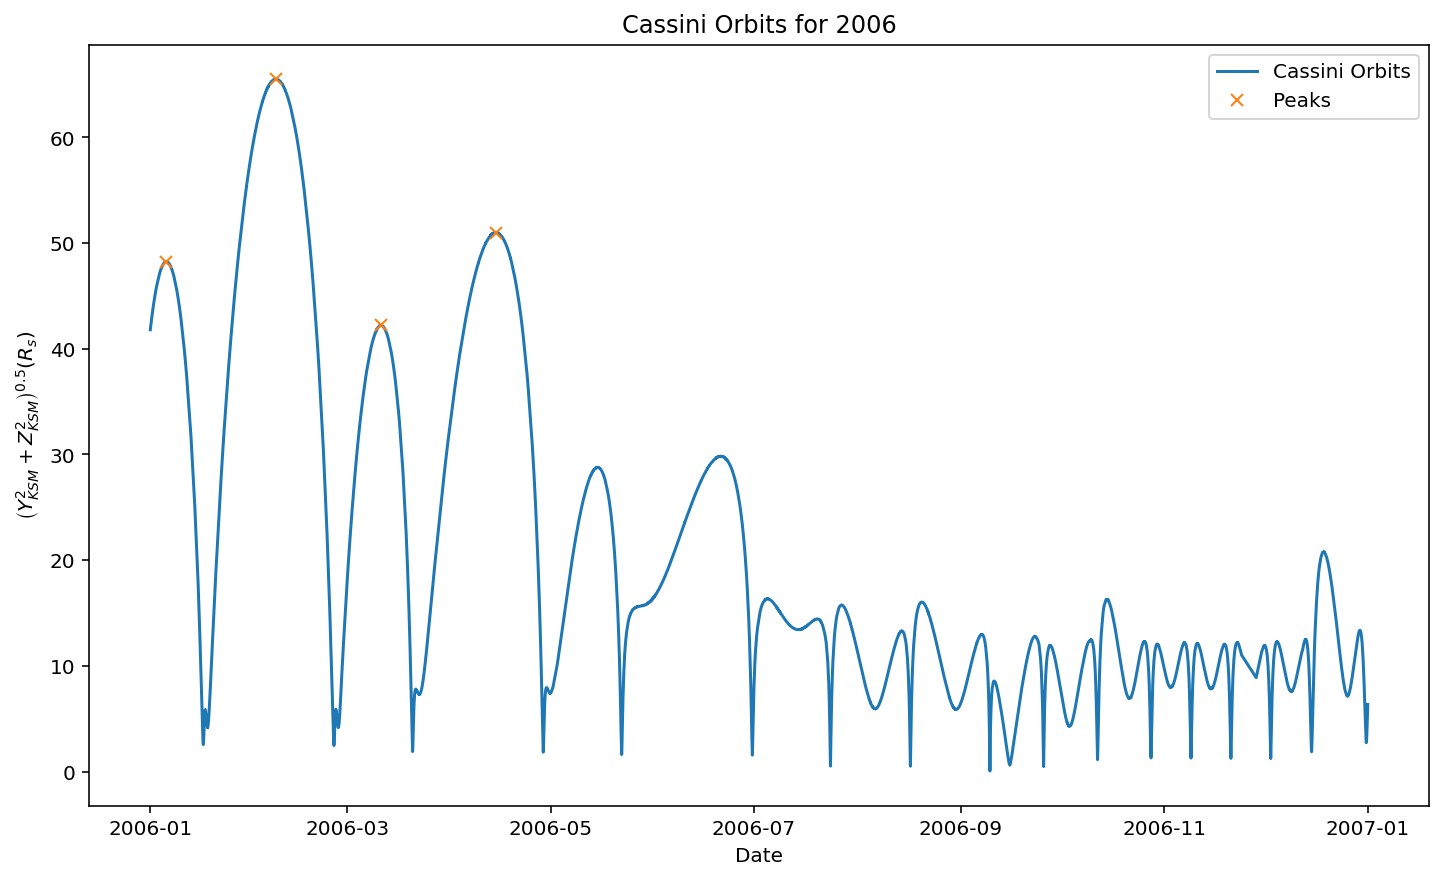

In [43]:
peaks,_ = find_peaks(Rs, height=36, distance=19000) #find peaks in orbits

#plot all Casinni orbits in specified year showing peaks
plt.figure()
plt.plot(data.index,Rs, label="Cassini Orbits")
plt.plot(data.index[peaks], Rs[peaks], "x", label="Peaks")
plt.xlabel("Date")
plt.ylabel(r"$\left(Y_{KSM}^2 + Z_{KSM}^2\right)^{0.5} \left(R_s\right)$")
plt.title("Cassini Orbits for %s"%year)
plt.legend();

In [44]:
#Define function that retrieves a given orbit from the calculated peaks
def getorbit(data, n, peaks):
    """Gets an orbit from the specified year."""

    orbit = data[peaks[n-1]:peaks[n]]
    
    return orbit

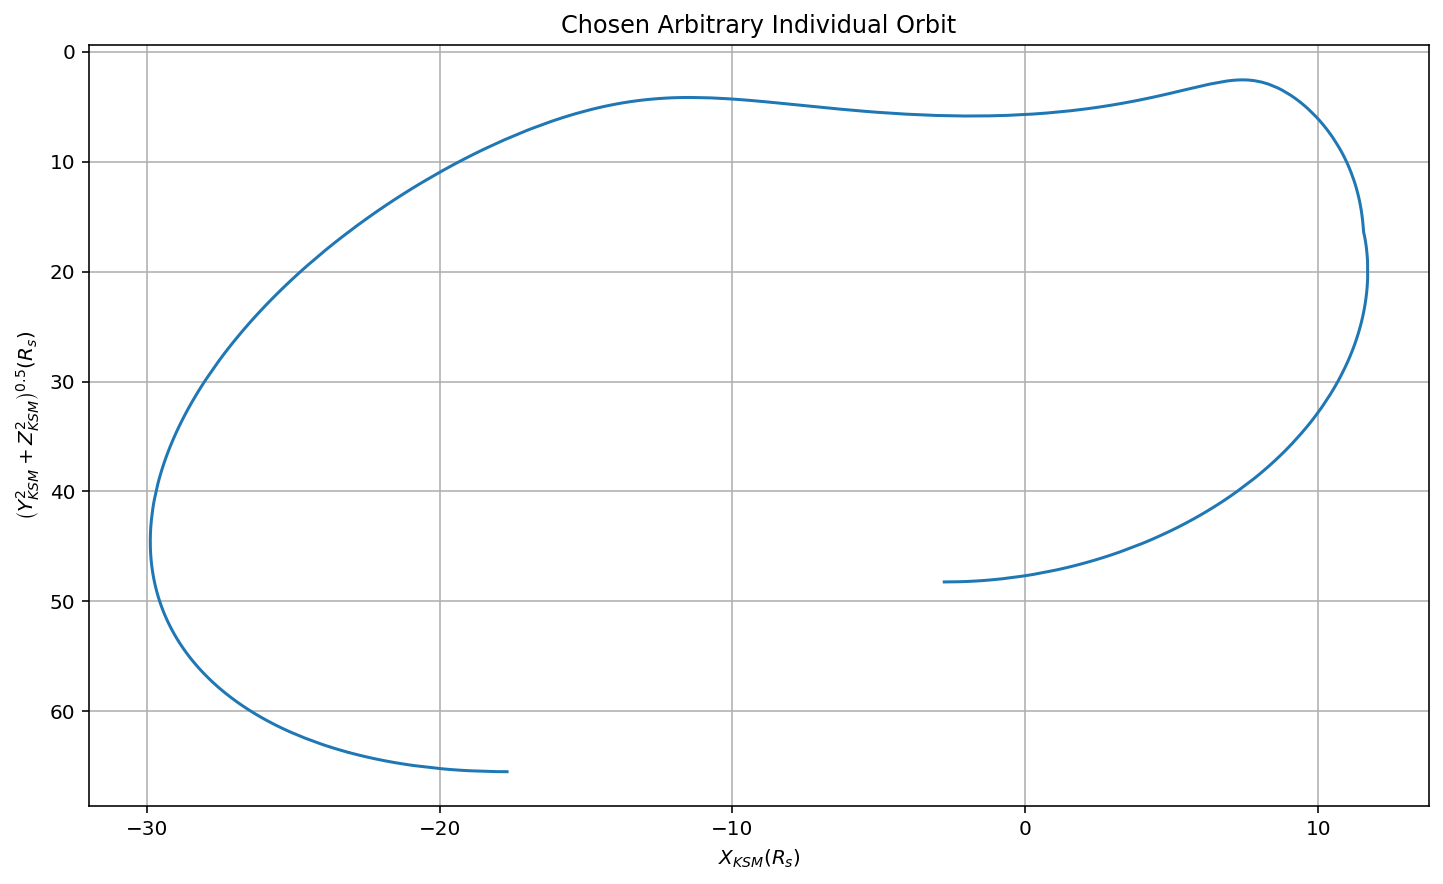

In [45]:
#retrieve an arbitrary orbit
orbit1 = getorbit(data, 1, peaks)

fig, ax = plt.subplots()
ax.plot(orbit1['X'], orbit1['Rs'], label="Orbit")
ax.grid()
ax.invert_yaxis()
ax.set_title("Chosen Arbitrary Individual Orbit")
ax.set_xlabel(r"$X_{KSM}  \left(R_s\right)$")
ax.set_ylabel(r"$\left(Y_{KSM}^2 + Z_{KSM}^2\right)^{0.5} \left(R_s\right)$");

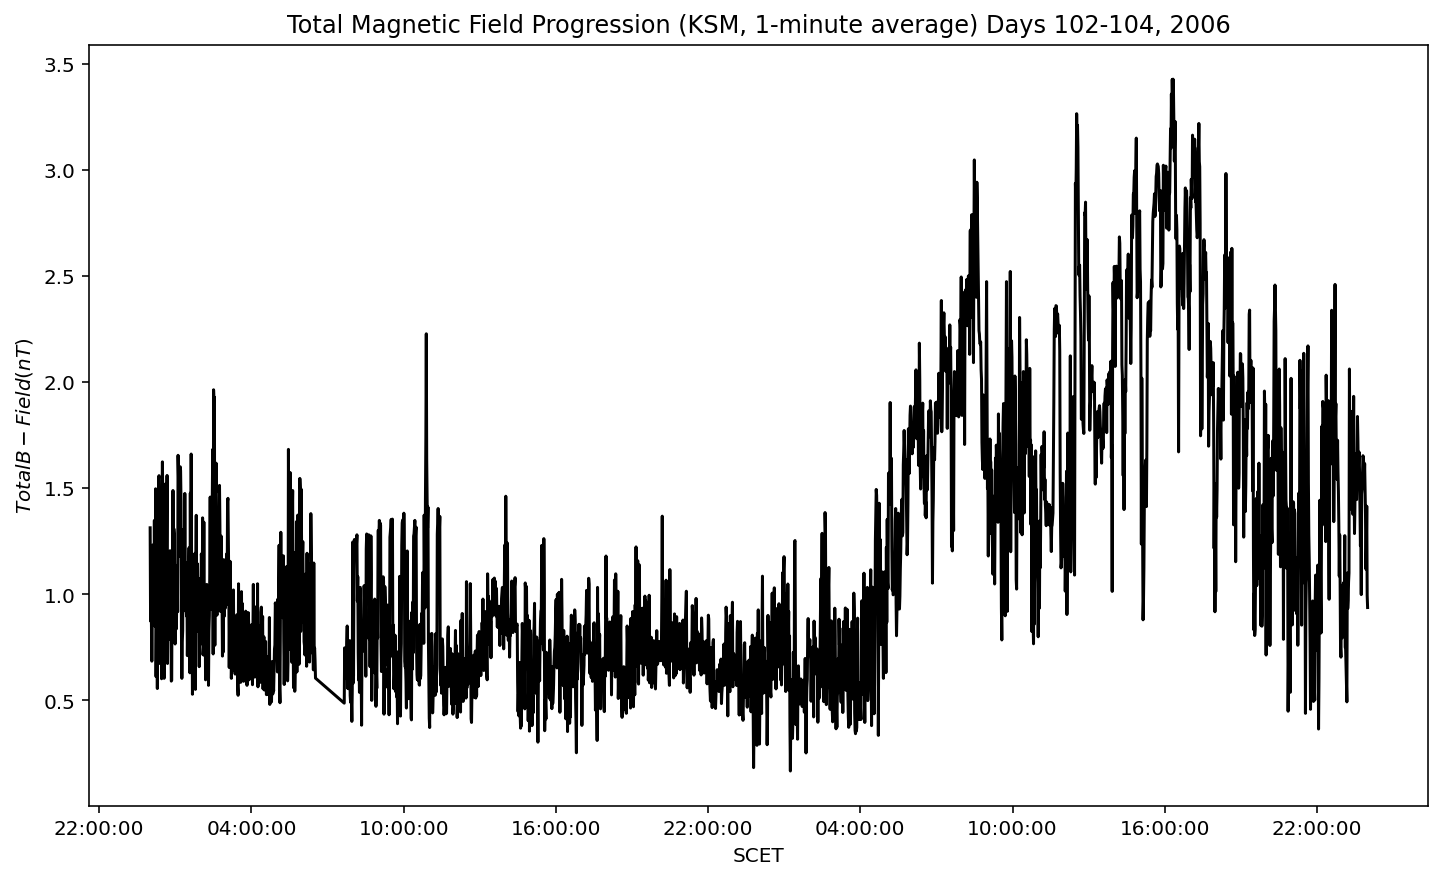

In [71]:
#define limits of plot
start_day = 102
end_day = 104


#calculate start and end dates as well as their indices
first_day = datetime(int(year), 1, 1)
start_date = pd.Timestamp(first_day + timedelta(start_day-1, 30))
start_index = list(data.index).index(start_date)
end_date = pd.Timestamp(first_day + timedelta(end_day-1, 30))
end_index = list(data.index).index(end_date)

#retrieve data for specified days for B_tot, Elevation, and Azimuth
timeframe = data.index[start_index:end_index]
B_tot = data["Btotal"][start_index:end_index]

#plot total B field for the orbit
fig, ax = plt.subplots()

hours = mdates.HourLocator(interval = 6)
h_fmt = mdates.DateFormatter('%H:%M:%S')

ax.plot(timeframe, B_tot, "black", label="$B_{tot}$")
ax.set_title("Total Magnetic Field Progression (KSM, 1-minute average) Days %s-%s, %s"%(str(start_day), str(end_day), str(year)))
ax.set_xlabel('SCET')
ax.set_ylabel(r'$Total B-Field \left(nT\right)$')
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(h_fmt);

### Calculating the Elevation and Azimuthal Angles:

The elevation angle $\lambda$ is defined as the angle between the field vector $B_z$ and its projection onto the XY plane. This definition implies that $\lambda$ is given by the equation: 

$$ \lambda = \arctan\left(\frac{B_z}{\left(B_x^2 + B_y^2\right)^\frac{1}{2}}\right) \tag{1}$$

where $B_x$, $B_y$, and $B_z$ are the components of the magnetic field in the KSM coordinate system. Moreover, we define the azimuthal angle $\delta$ as the angle between the anti-sunward direction (i.e $-x$) and the projection of the field onto the XY plane such that: 

$$ \delta = \arccos\left(\frac{-B_x}{\left(B_x^2 + B_y^2\right)^\frac{1}{2}}\right) \tag{2}$$

In the code cell below we add columns for these two angles to our data frame for the specified year and plot them afterwards. 

In [10]:
#create columns for angles in question
data["Elevation"] = np.degrees(np.arctan(data["BZ"]/(data["BX"]**2 + data["BY"]**2)**0.5))
data["Azimuth"] = np.degrees(np.arccos(-data["BX"]/(data["BX"]**2 + data["BY"]**2)**0.5))

print(data)

                        BX     BY     BZ  Btotal       X       Y      Z  \
Time                                                                      
2005-01-01 00:00:30 -0.121 -0.378 -0.210   0.450  19.440 -56.253  3.745   
2005-01-01 00:01:30 -0.119 -0.380 -0.206   0.449  19.441 -56.253  3.745   
2005-01-01 00:02:30 -0.123 -0.370 -0.215   0.446  19.442 -56.252  3.746   
2005-01-01 00:03:30 -0.113 -0.371 -0.208   0.441  19.443 -56.252  3.746   
2005-01-01 00:04:30 -0.119 -0.363 -0.228   0.445  19.444 -56.251  3.746   
...                    ...    ...    ...     ...     ...     ...    ...   
2005-12-31 23:55:30  1.644  1.946 -0.423   2.583 -11.056 -41.606 -3.803   
2005-12-31 23:56:30  1.671  1.912 -0.423   2.574 -11.055 -41.608 -3.803   
2005-12-31 23:57:30  1.664  1.936 -0.454   2.593 -11.054 -41.610 -3.803   
2005-12-31 23:58:30  1.685  1.966 -0.388   2.618 -11.053 -41.612 -3.803   
2005-12-31 23:59:30  1.705  1.976 -0.333   2.631 -11.052 -41.614 -3.803   

                     Loc

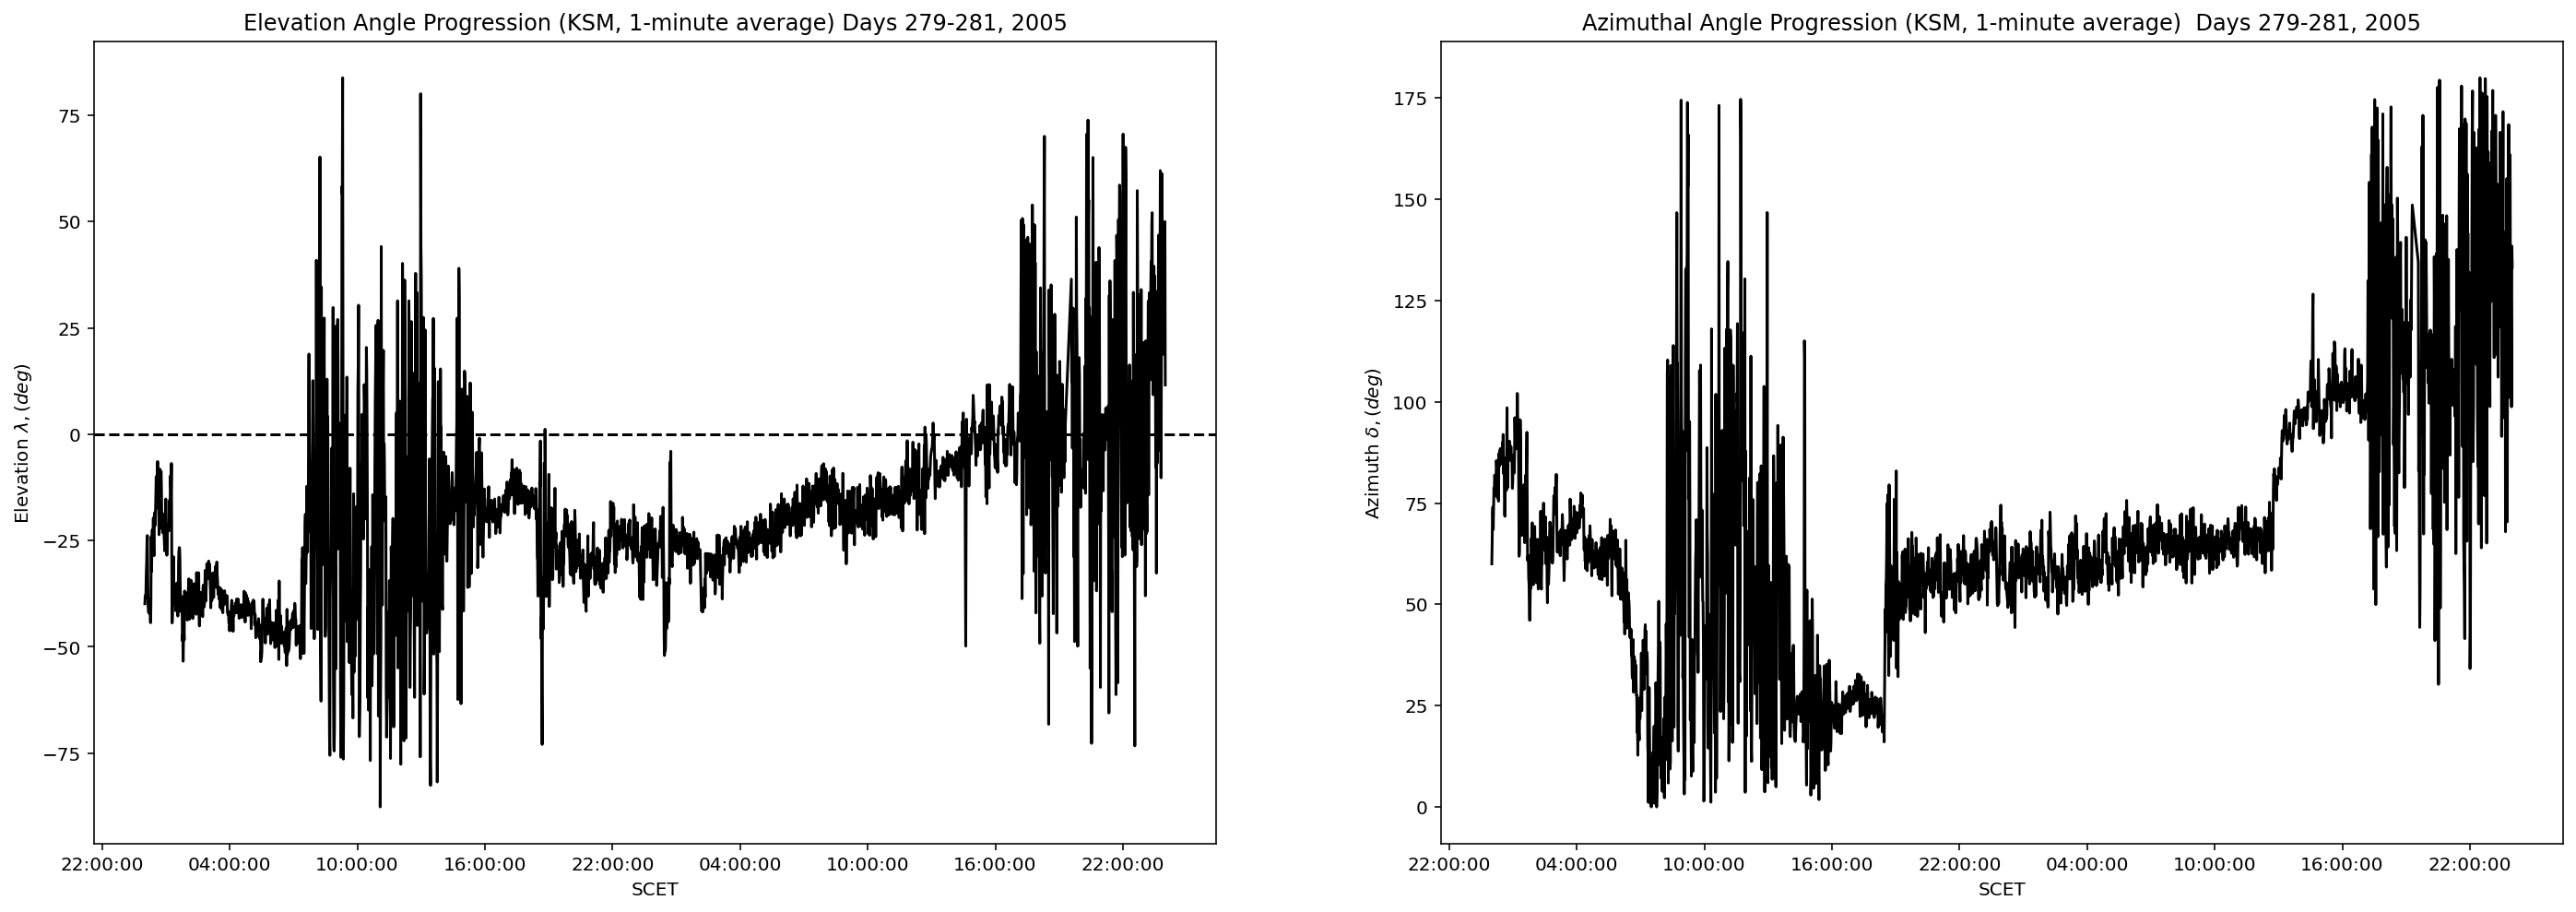

In [11]:
#retrieve data for specified days
elevation = data["Elevation"][start_index:end_index]
azimuth = data["Azimuth"][start_index:end_index]

#plot angles for the orbit
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(24,8))

hours = mdates.HourLocator(interval = 6)
h_fmt = mdates.DateFormatter('%H:%M:%S')

ax[0].plot(timeframe, elevation, "black", label="$\lambda$")
ax[0].set_title("Elevation Angle Progression (KSM, 1-minute average) Days %s-%s, %s"%(str(start_day), str(end_day), str(year)))
ax[0].set_xlabel('SCET')
ax[0].set_ylabel(r'Elevation $ \lambda, \left(deg\right)$')
ax[0].axhline(0, color= "black", ls="--")
ax[0].xaxis.set_major_locator(hours)
ax[0].xaxis.set_major_formatter(h_fmt)

ax[1].plot(timeframe, azimuth, "black", label="$\delta$")
ax[1].set_title("Azimuthal Angle Progression (KSM, 1-minute average)  Days %s-%s, %s"%(str(start_day), str(end_day), str(year)))
ax[1].set_xlabel('SCET')
ax[1].set_ylabel(r'Azimuth $\delta, \left(deg\right)$')
ax[1].xaxis.set_major_locator(hours)
ax[1].xaxis.set_major_formatter(h_fmt)

In [12]:
def plot_KSM(data, year, start_day, end_day, xFormat = "Hour"):
    """This function plots the Elevation, Azimuth and Total B_Field for a specified orbit """

    #calculate start and end dates as well as their indices
    
    start_date = pd.Timestamp(first_day + timedelta(start_day-1, 30))
    end_date = pd.Timestamp(first_day + timedelta(end_day-1, 30))

    #use the nearest available start and end dates if they are not in data
    try:
        start_index = list(data.index).index(start_date)
        end_index = list(data.index).index(end_date)
        print("Start Date: ",start_date)
        print("End Date: ",end_date)

    except ValueError:
        start_index = data.index.get_loc(start_date, method="nearest")
        end_index = data.index.get_loc(end_date, method="nearest")
        print("Start Date: ",data.index[start_index])
        print("End Date: ",data.index[end_index])

    #retrieve data for specified days for B_tot, Elevation, and Azimuth
    timeframe = data.index[start_index:end_index]
    B_tot = data["Btotal"][start_index:end_index]
    elevation = data["Elevation"][start_index:end_index]
    azimuth = data["Azimuth"][start_index:end_index]

    #format dates for x-axis in plot
    if xFormat == "Hour":
        xlocator = mdates.HourLocator(interval = 3)
        x_fmt = mdates.DateFormatter('%H:%M:%S')
    elif xFormat == "Day": 
        xlocator = mdates.DayLocator(interval = 1)
        x_fmt = mdates.DateFormatter("%m/%d")
    
    fig = plt.figure(figsize =(20,10))
    gs = gridspec.GridSpec(nrows=3, ncols=1)

    ax1 = plt.subplot(gs[0])
    ax1.set_title("Cassini VHM Data (KSM, 1-minute average) Days %s-%s, %s"%(str(start_day), str(end_day), year))
    ax1.plot(timeframe, elevation, "black", label="$\lambda$")
    ax1.set_ylabel(r'Elevation $ \lambda, \left(deg\right)$')
    ax1.axhline(0, color= "black", ls="--")

    ax2 = plt.subplot(gs[1],sharex=ax1)
    ax2.plot(timeframe, azimuth, "black", label="$\delta$")
    ax2.set_ylabel(r'Azimuth $\delta, \left(deg\right)$')

    ax3 = plt.subplot(gs[2],sharex=ax1)
    ax3.plot(timeframe, B_tot,'black',label="$Total B-Field $")
    ax3.set_ylabel(r'$Total B-Field \left(nT\right)$')
    ax3.xaxis.set_major_locator(xlocator)
    ax3.xaxis.set_major_formatter(x_fmt)
    ax3.set_xlabel('SCET')
    ax3.xaxis.set_label_coords(-0.02, -0.045)
    plt.subplots_adjust(hspace=.0)

    plt.setp(ax1.get_xticklabels(),visible=False)
    plt.setp(ax2.get_xticklabels(),visible=False)
    plt.xlim([start_date, end_date])
#    time_index = []

#    model = "rbf"
#    algo = rpt.Pelt(model=model).fit(B_tot)
#    result = algo.predict(pen=10)
#    rpt.display(B_tot, result, figsize=(10, 6))
#    plt.show()
    ############################################################
    ##There maybe a better way for this hard code part....
    ############################################################
#     for i in ['2005-10-06 03:00:30','2005-10-06 06:00:30','2005-10-06 09:00:30','2005-10-06 12:00:30',
#            '2005-10-06 15:00:30', '2005-10-06 18:00:30', '2005-10-06 21:00:30','2005-10-07 00:00:30',
#            '2005-10-07 03:00:30','2005-10-07 06:00:30', '2005-10-07 09:00:30' ,'2005-10-07 12:00:30',
#            '2005-10-07 15:00:30','2005-10-07 18:00:30','2005-10-07 21:00:30']:

#         try:
#             time_index.append(list(data.index).index(i))

#         except ValueError:
#             time_index.append(data.index.get_loc(i, method="nearest"))

#     table_content = [[round(j,2) for j in [data["Rs"][i] for i in time_index]],
#                [data["Z"][i] for i in time_index],
#                [data["LocalHour"][i] for i in time_index]]
#     rows = [r'Range(R_s)', 'Latutude(deg)', 'SLT(dec hr)']
#     Loc='right'
#     the_table = plt.table(cellText=table_content,
#                           rowLabels=rows,
#                           cellLoc='center',
#                           loc='bottom',
#                           bbox=[0.019,-0.76,0.945,0.65])#x,y,w,h
#     the_table.scale(1,2.5)

#     the_table.auto_set_font_size(False)
#     the_table.set_fontsize(10)
#     plt.subplots_adjust(left=0.2, bottom=0.2)
#     plt.show();

In [13]:
#[pd.Timestamp(start_date + timedelta(hours=3*i)) for i in range()

Start Date:  2005-10-06 00:00:30
End Date:  2005-10-08 00:00:30


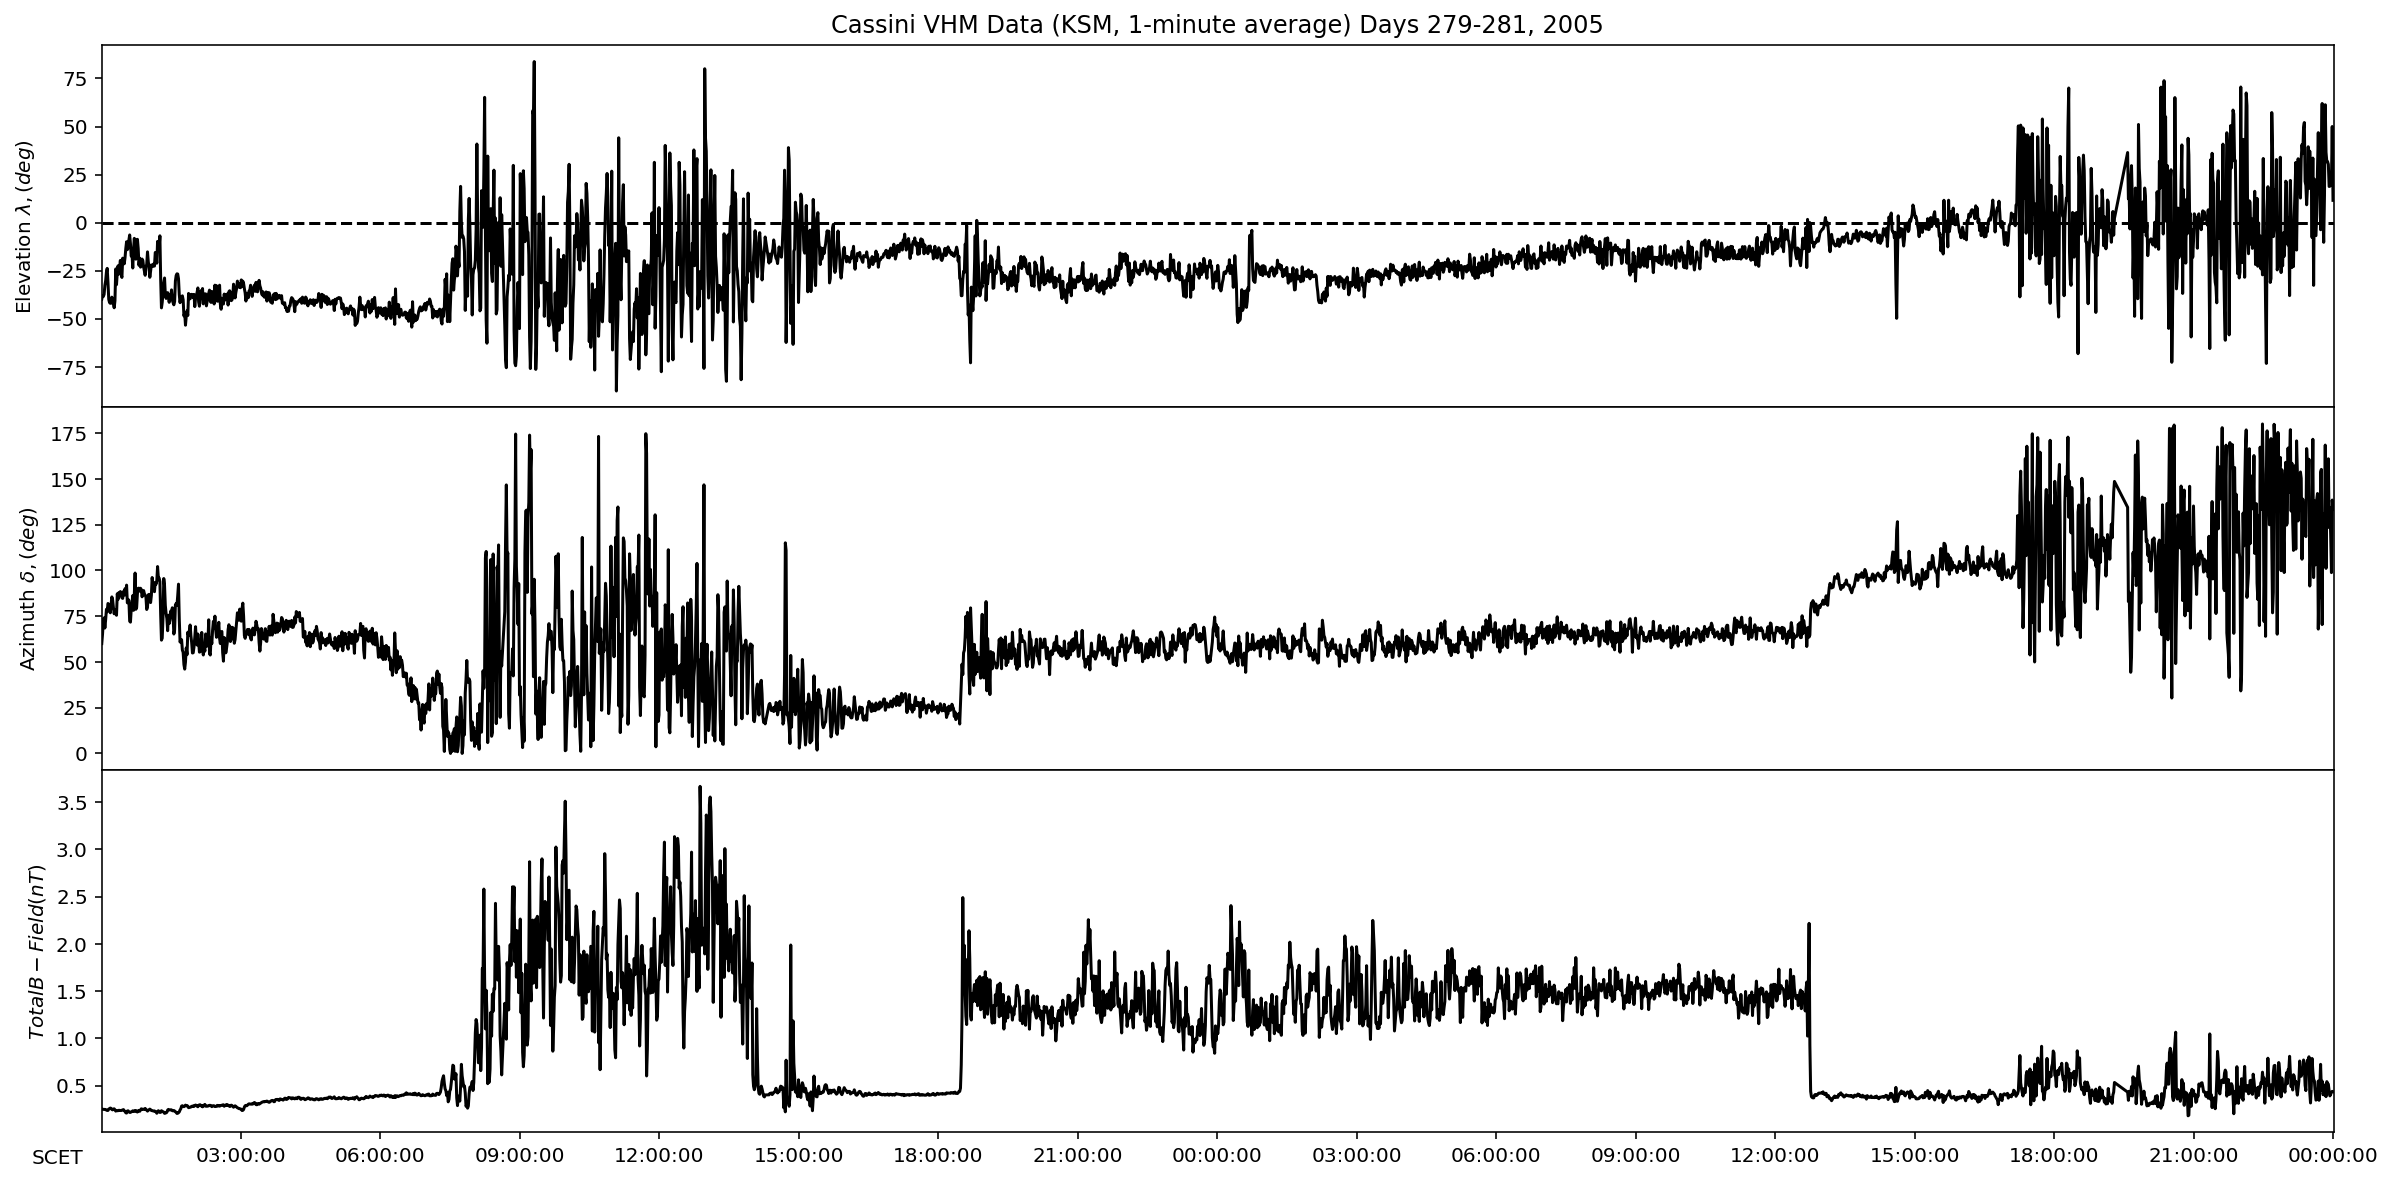

In [14]:
#define start and end days
year = 2005
start_day = 279
end_day = 281
#plot all three features in a single plot
plot_KSM(data, year, start_day, end_day)
#Plot the table under the graph


#### Make Sure Elevation and Azimuthal Angles are Correctly Calculated by Plotting the Data for Days 179-180, 2004

In [15]:
#define a function that fills the data and makes the time column the index of the data frame
def fill_data(data): 
    """Add columns for Rs=(x**2 + y**2)**0.5 and the elevation and azimuthal angles."""
    #Set the index as the 'Time' column
    data["Time"] = pd.to_datetime(data["Time"], format='%Y/%m/%d %H:%M:%S')
    data = data.set_index("Time")

    #add columns
    y = data["Y"]
    z = data["Z"]
    data['Rs'] = ((z*z)+(y*y))**0.5
    data["Elevation"] = np.degrees(np.arctan(data["BZ"]/(data["BX"]**2 + data["BY"]**2)**0.5))
    data["Azimuth"] = np.degrees(np.arccos(-data["BX"]/(data["BX"]**2 + data["BY"]**2)**0.5))

    return data

In [16]:
#get data for 2004
data_2004 = get_data(2004)

In [17]:
#add columns for Rs, lambda and azimuth
data_2004 = fill_data(data_2004)

Start Date:  2004-06-27 00:00:30
End Date:  2004-06-29 00:00:30


Start Date:  2004-07-12 22:35:30
End Date:  2004-07-14 00:00:30


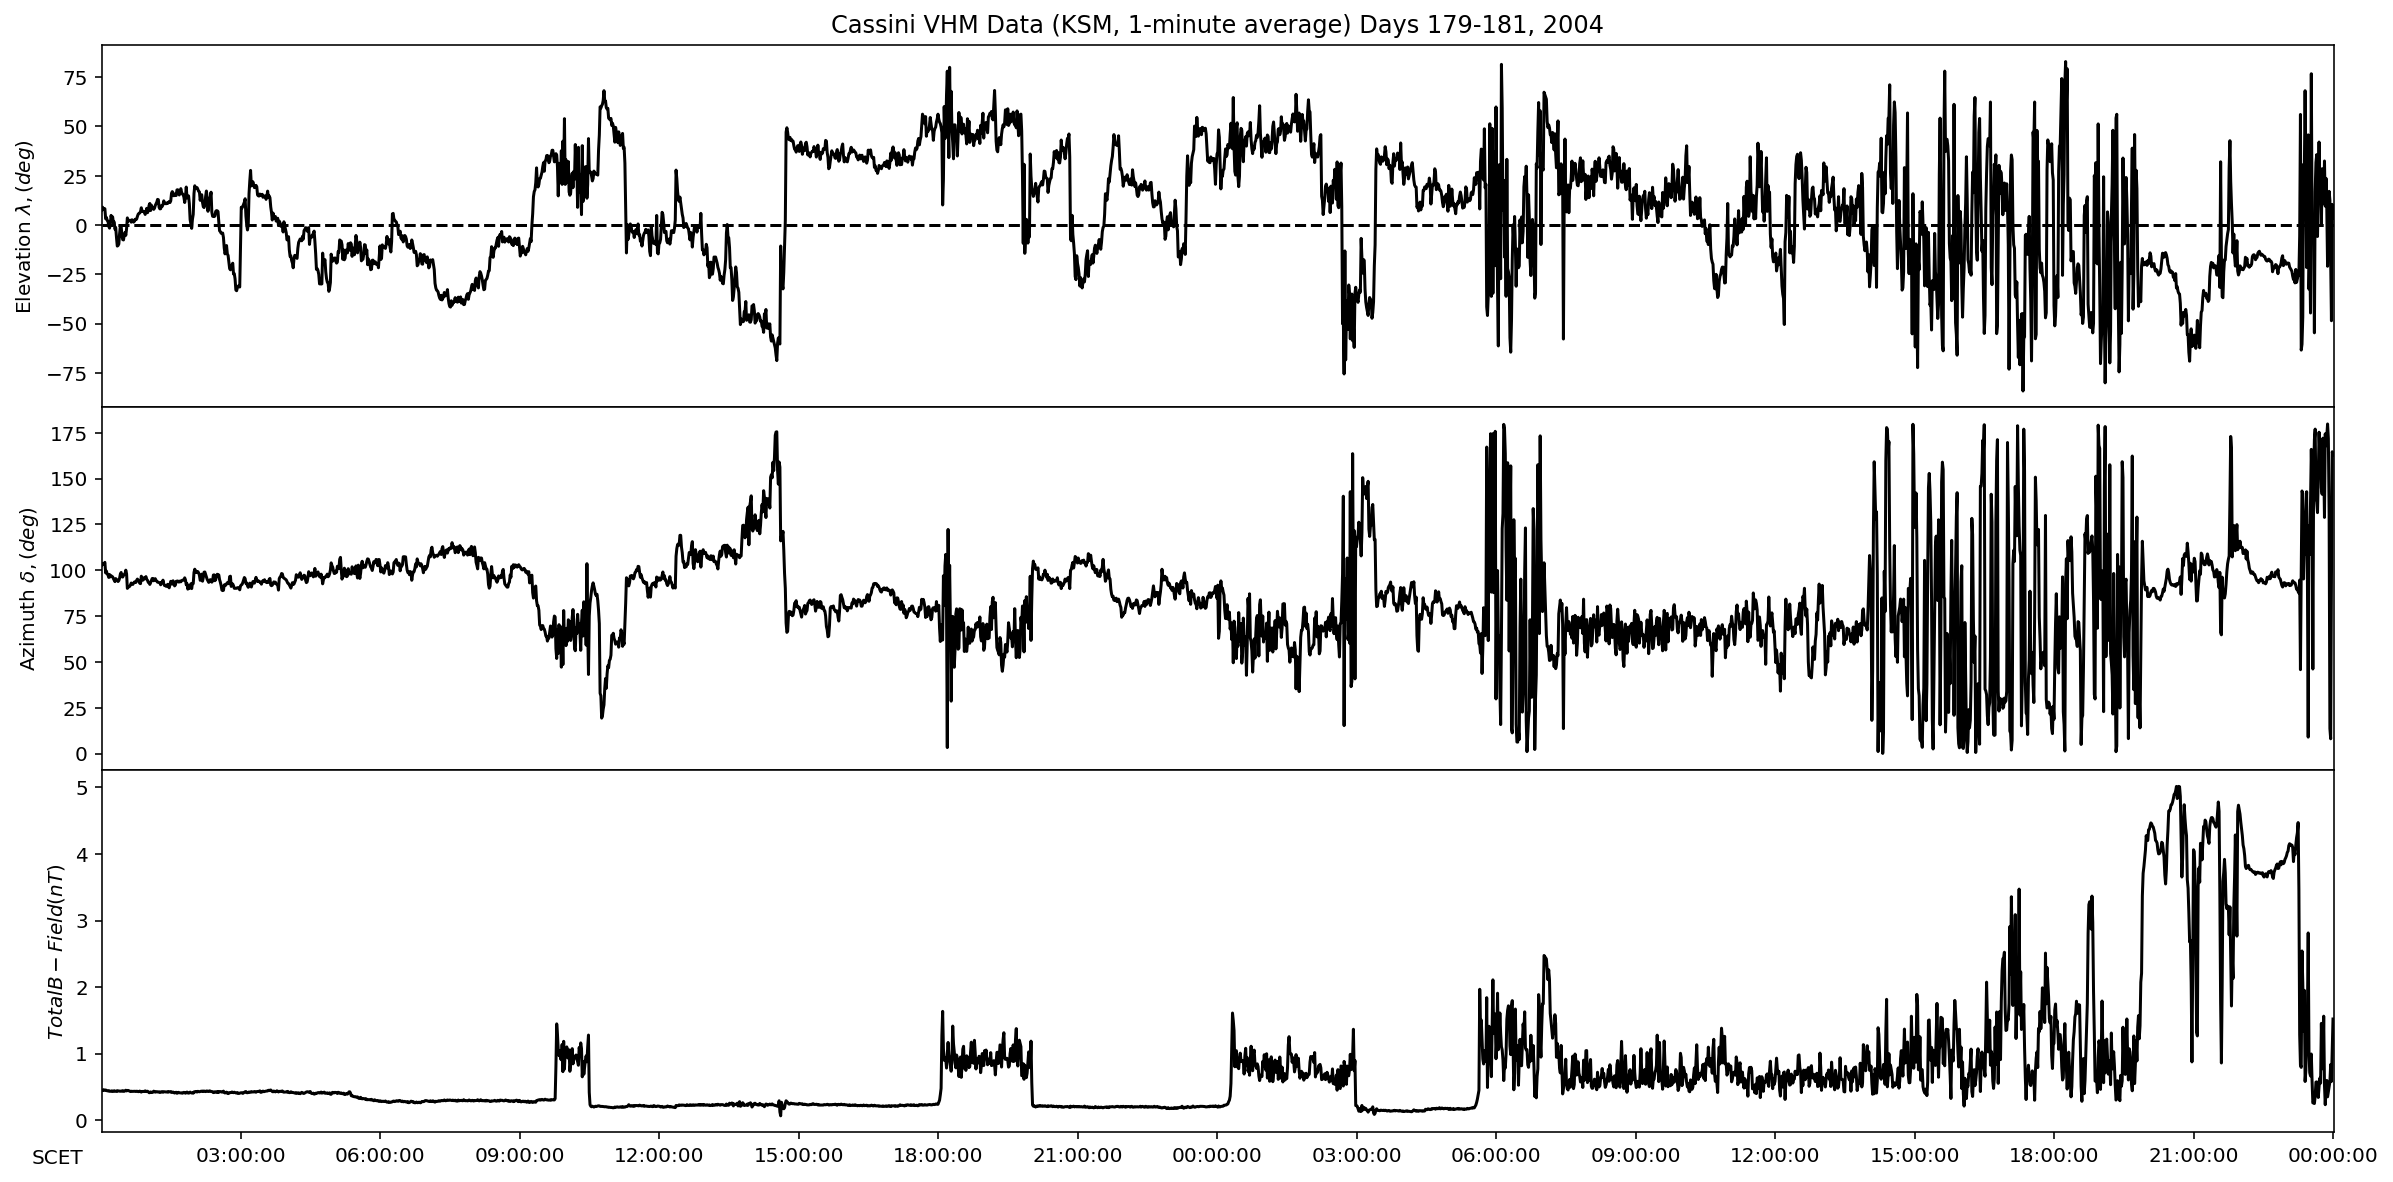

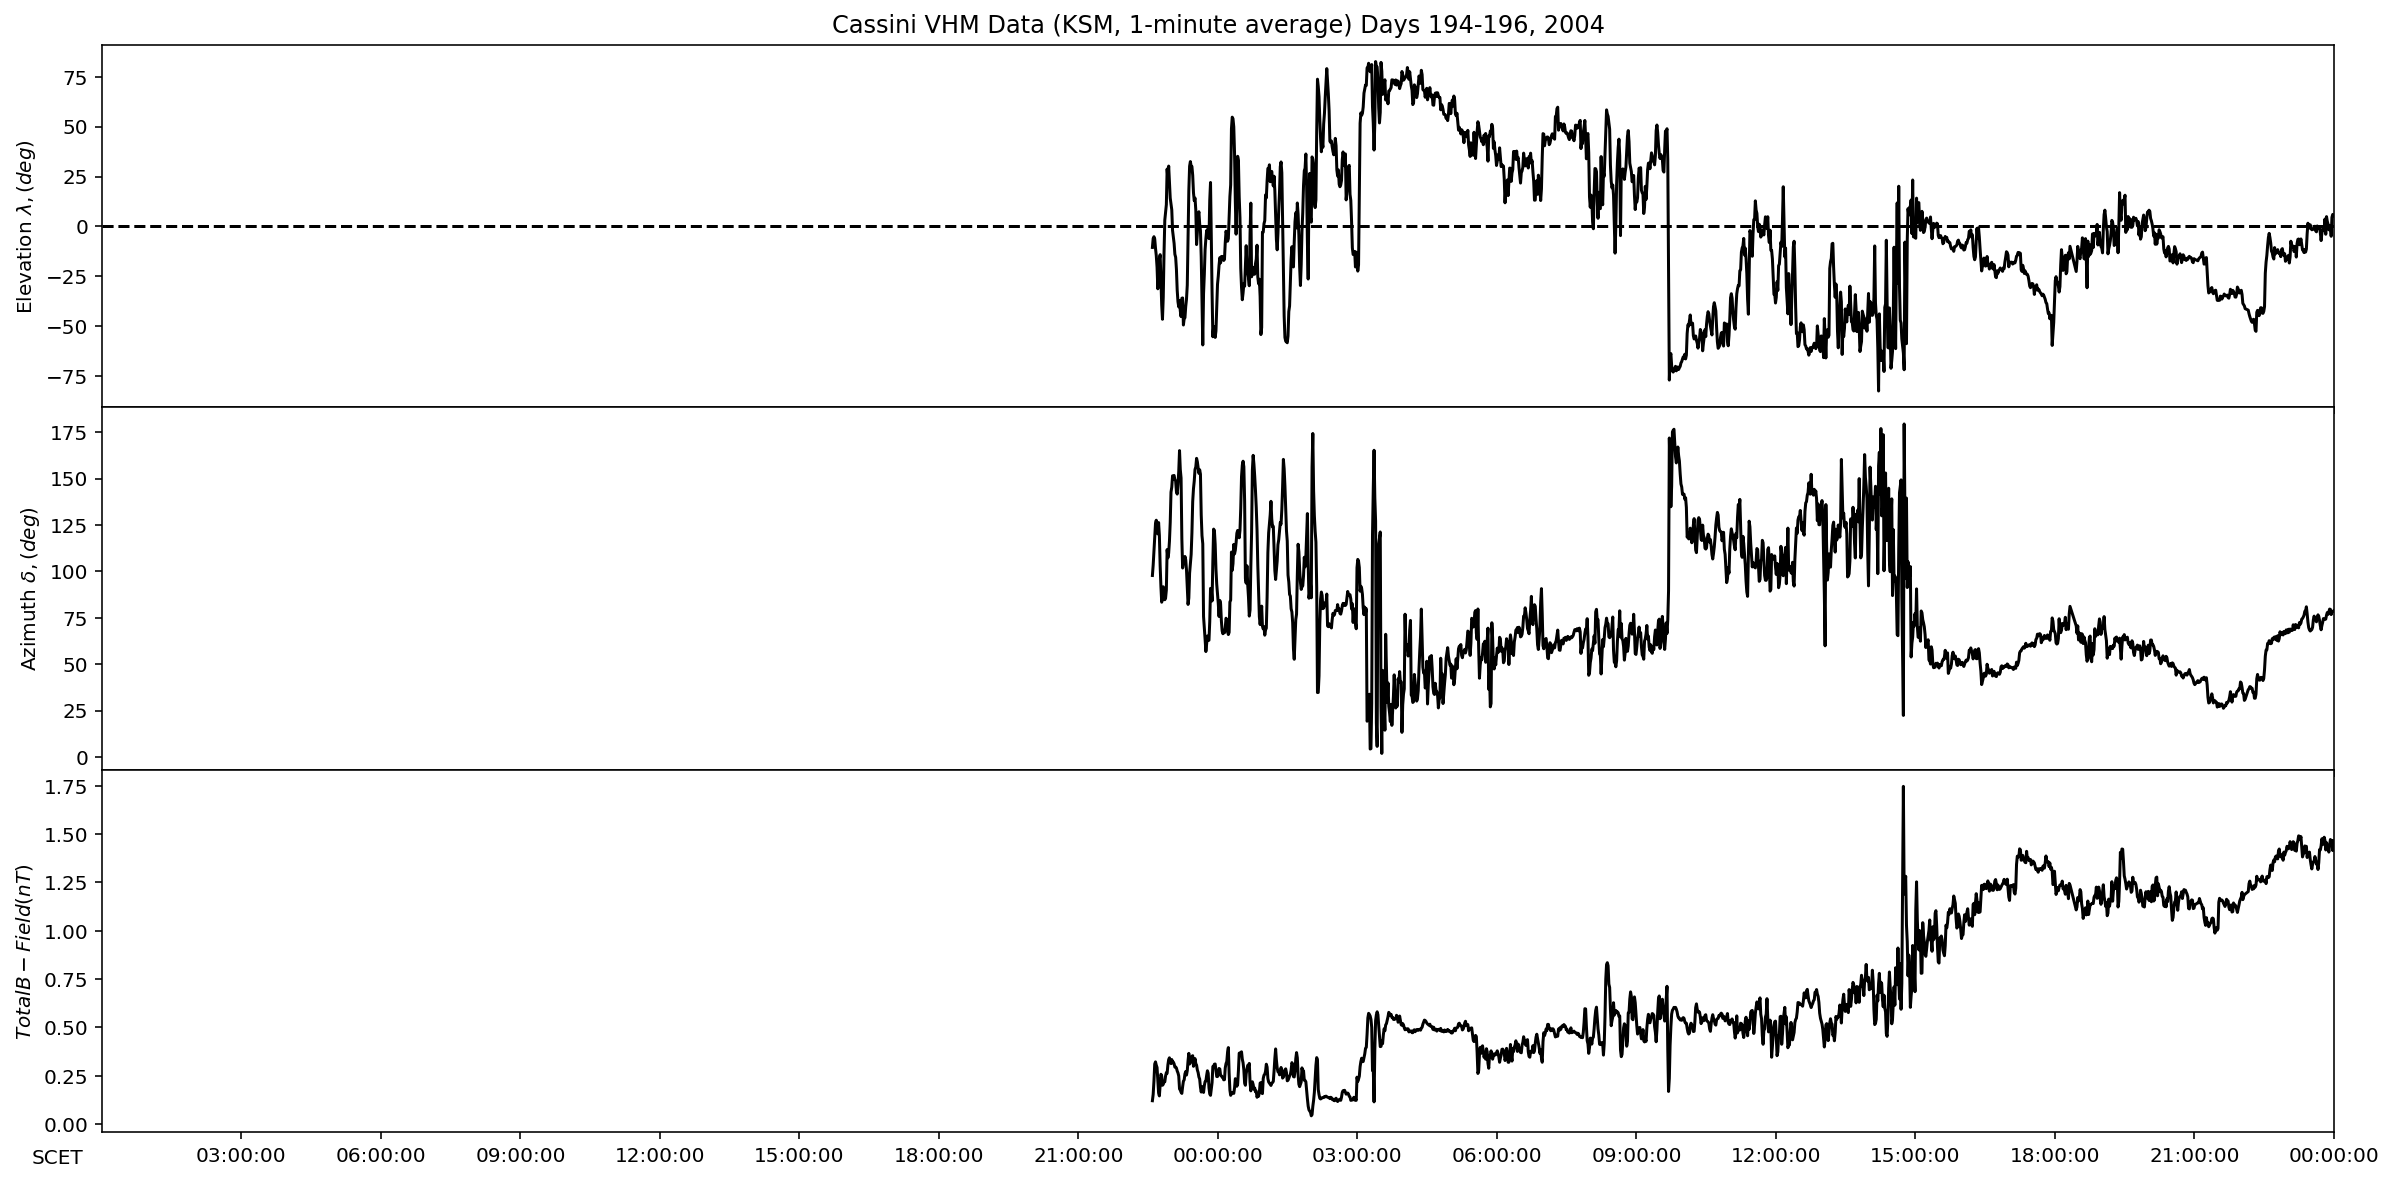

In [18]:
#define start and end days
year = 2004
start_day = 179
end_day = 181

#plot all three features for the specified days
plot_KSM(data_2004, year, start_day, end_day) #Figure 2 on Achilleos et al.
plot_KSM(data_2004, year, 194, 196) #Figure 3 on Achilleos et al.


### Notes: 

The plot corresponding to Figure 3 on Achilleos et al. shows how there is no data available for the exact specified dates (Days 194-196) and it has to find the nearest available date, which ends up being from 2004-07-12 22:35:30 until 2004-07-14 00:00:30. 

In [19]:
def get_day_data(daymin, daymax, year):
    """Returns a sample of the data for a given day range and year"""
    global get_data, fill_data

    yeardata = get_data(year)
    yeardata = fill_data(yeardata)
    start_date = pd.Timestamp(datetime(int(year), 1, 1) + timedelta(daymin-1, 30))
    end_date = pd.Timestamp(datetime(int(year), 1, 1) + timedelta(daymax-1, 30))
    start_index = yeardata.index.get_loc(start_date, method="nearest")
    end_index = yeardata.index.get_loc(end_date, method="nearest")
    print("Sample start date: ",yeardata.index[start_index],"\nSample end date:",yeardata.index[end_index])
    yeardata = yeardata[start_index:end_index]

    return yeardata

def crossings_graph(daymin, daymax, year):
    """Plots the bow shock and magnetopause crossings."""
    global get_day_data

    #retrieve data for specified day range
    tempdata = get_day_data(daymin, daymax, year)
    circledata = tempdata[::1440] #data points to use in plot to give a sense of the movement of the satellite

    #days appearing in circledata to annotate in plot
    days_annotation = [str(i+1) for i in list((circledata.index - datetime(year,1,1)).days)] #create list of strings with days

    #plot crossings
    fig, ax = plt.subplots(figsize=(8,12))
    ax.plot(tempdata['X'], tempdata['Rs'], color="black")
    ax.plot(circledata['X'], circledata['Rs'],"o", color="black")
    ax.plot(0, 0,'o',markersize=15, linewidth=30, mfc='none', color="black")
    ax.invert_yaxis()

    #annotate days in plot
    for i, day in enumerate(days_annotation):
        ax.annotate(day, (circledata['X'][i], circledata['Rs'][i]))
    ax.annotate("S", (0,0),xytext=(5,5),textcoords='offset points')

    ax.set_xlabel(r"$X_{KSM}  \left(R_s\right)$")
    ax.set_ylabel(r"$\left(Y_{KSM}^2 + Z_{KSM}^2\right)^{1/2} \left(R_s\right)$")
    ax.set_title("Bow Shock and Magnetopause Crossings\n During the SOI Orbit Projected into Cylindrical KSM Coordinates, Days %s-%s, %s"%(str(daymin), str(daymax), str(year)));

Start Date:  2004-06-26 00:00:30
End Date:  2004-07-14 00:00:30


Sample start date:  2004-06-26 00:00:30 
Sample end date: 2004-07-14 00:00:30


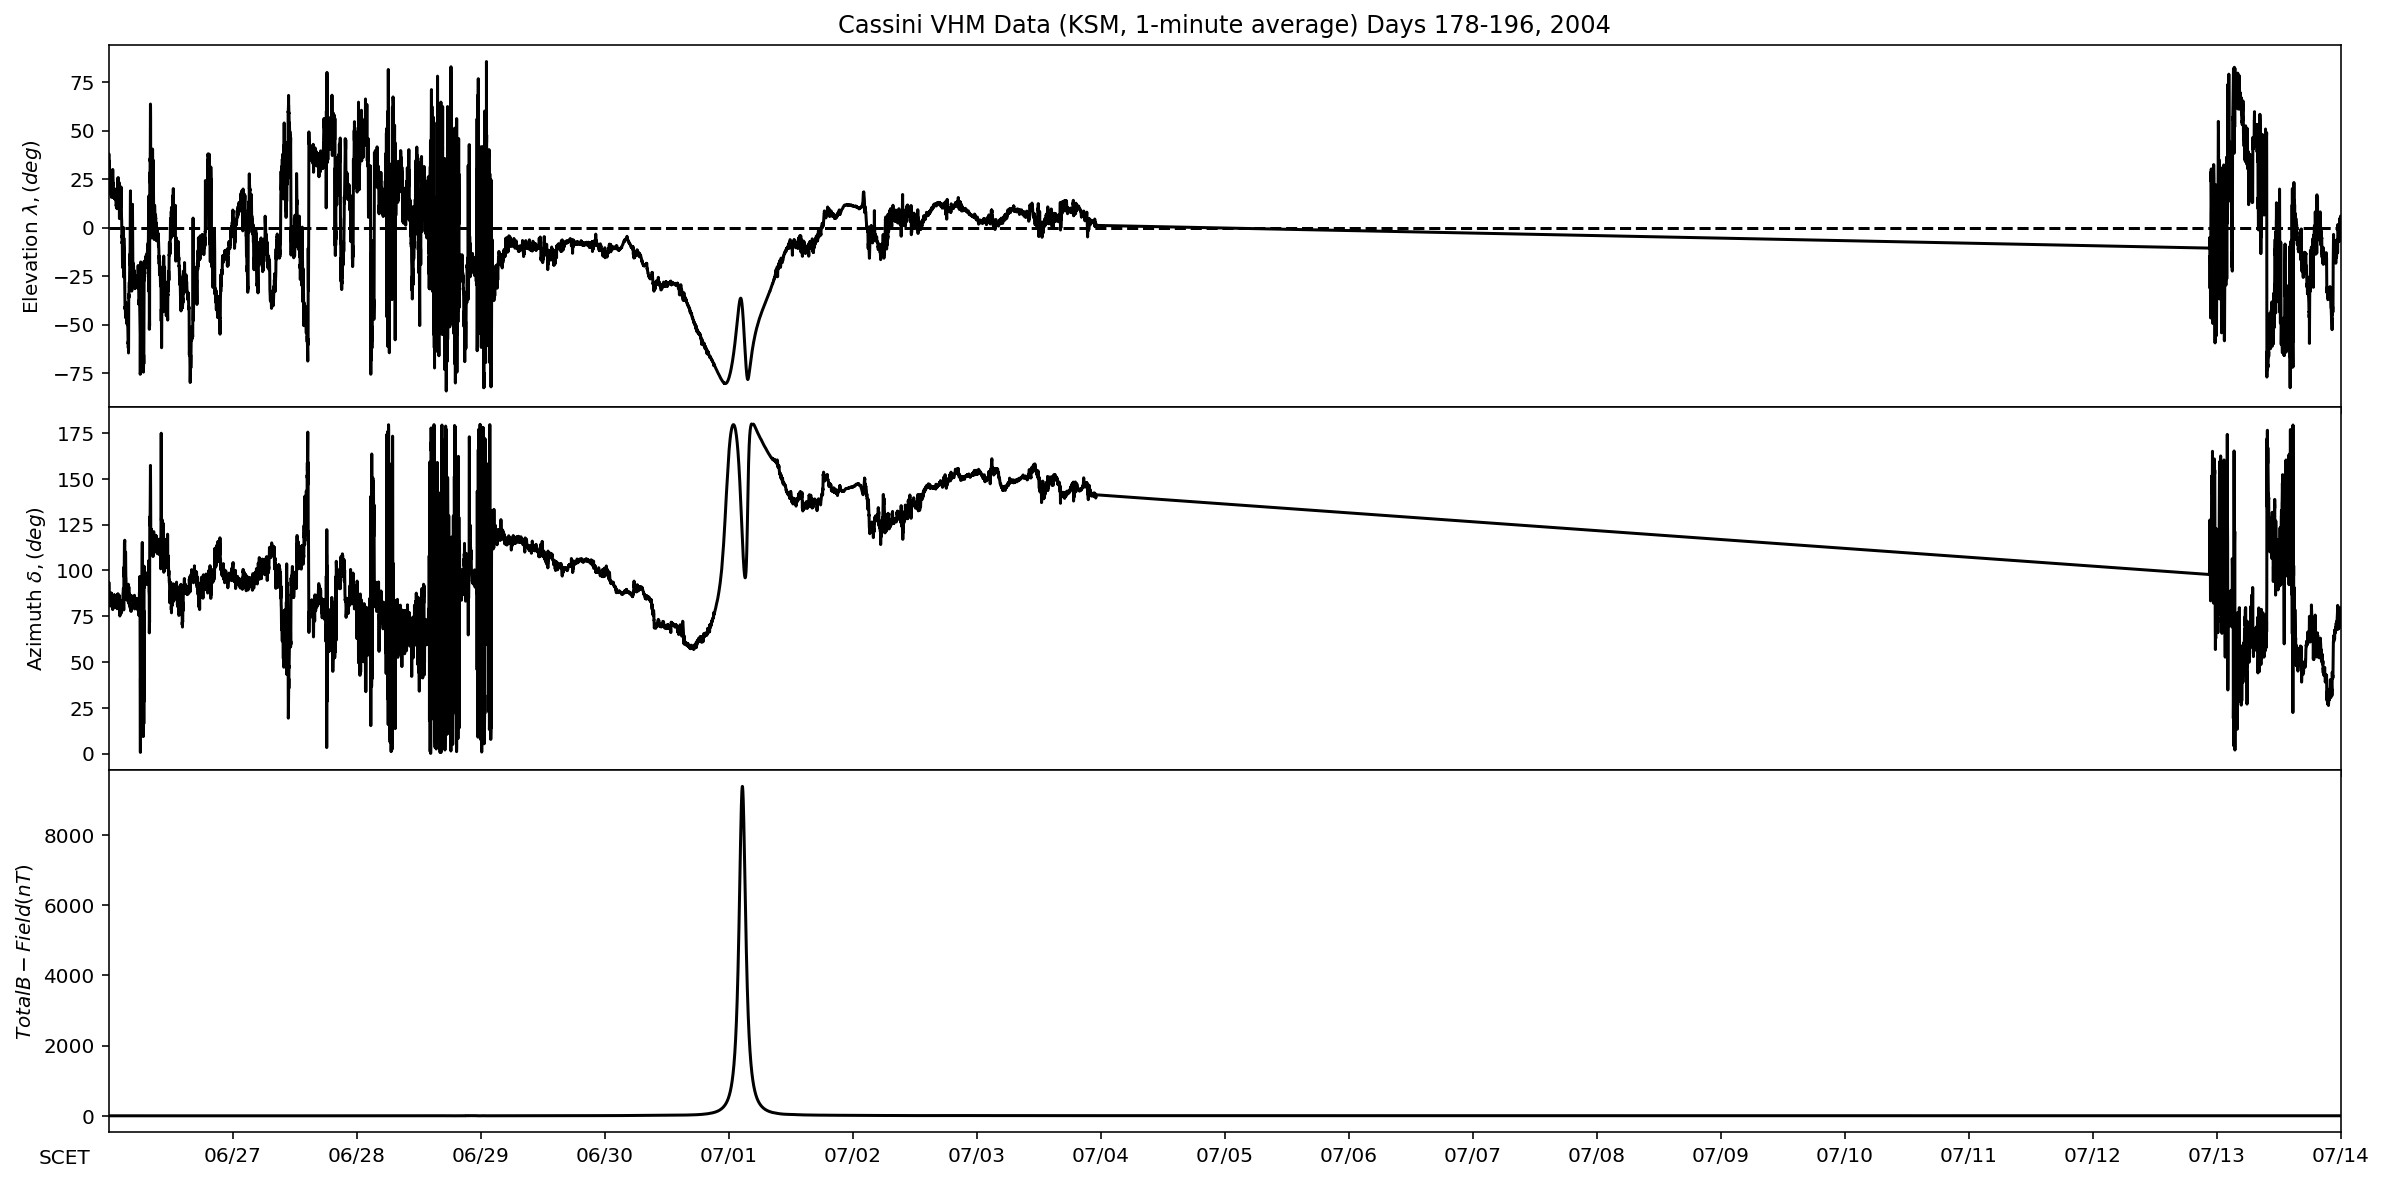

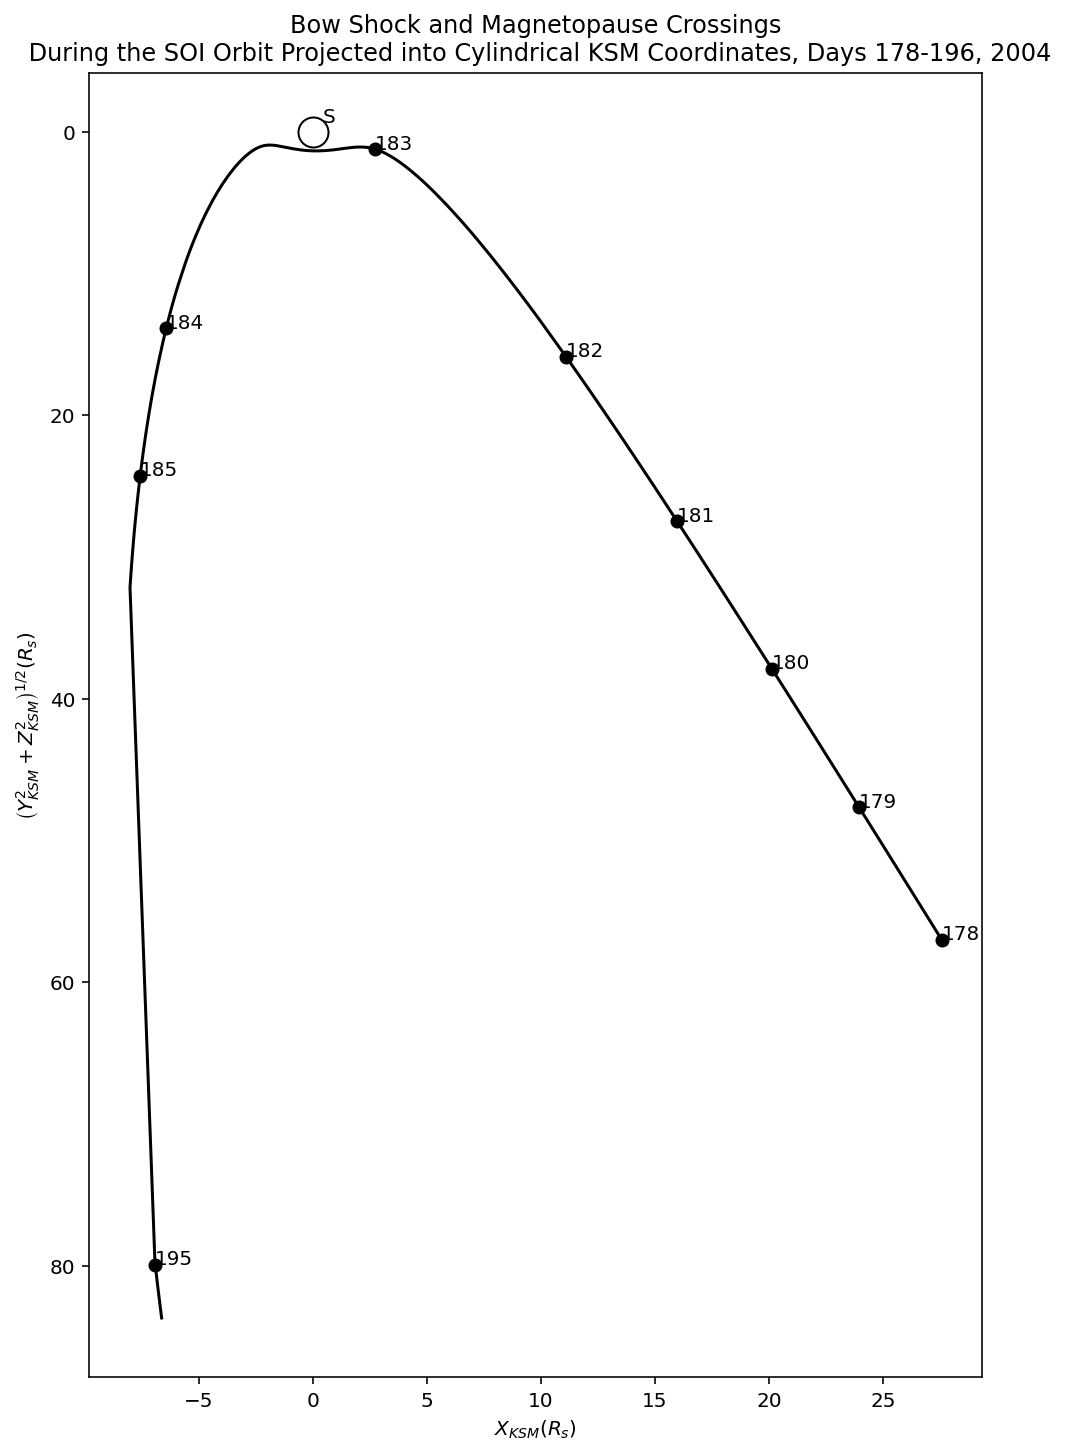

In [20]:
#define plot parameters
start = 178
end = 196
year = 2004

#plot bow shock and magnetopause crossings
plot_KSM(data_2004, year, start, end, xFormat = "Day") #plot features data
crossings_graph(start, end, year) #Figure 5 on Achileos et al.